# Self-balancing Ensemble Scores through Logarithmic PCA

Generally speaking, the integration formula for value-based sorting in recommendation systems, namely the predicted X-Through Rate ($\text{pXTR}$), consists of two fundamental forms: a multiplicative formula and an additive formula.

- Multiplicative formula: $\prod_j \left(1 + a_j \cdot \text{pXTR}_j\right)^{b_j}$

- Additive formula: $\sum_j c_j \cdot \text{pXTR}_j$

## Which Form is Better

The multiplicative formula is better. Here are the reasons:

These two forms, when $a_j \cdot \text{pXTR}_j$ is very small, are almost equivalent mathematically (first-order Taylor expansion) because multiplication is essentially addition in the logarithmic domain:

$$\log\left[\prod_j \left(1 + a_j \cdot \text{pXTR}_j\right)^{b_j}\right]=\sum_j b_j\cdot\log\left(1+a_j \cdot \text{pXTR}_j\right)\approx \sum_j a_j b_j\cdot \text{pXTR}_j$$

However, as $a_j \cdot \text{pXTR}_j$ continues to increase, we have

$$\log\left[\prod_j \left(1 + a_j \cdot \text{pXTR}_j\right)^{b_j}\right]\approx\sum_j b_j\cdot\log\left(a_j \cdot \text{pXTR}_j\right)= \sum_j b_j\cdot \log\left(\text{pXTR}_j\right) + C$$

Which form is better depends on the prior distribution of the predicted scores $\text{pXTR}_j$, which typically more closely resembles a log-normal distribution:

- Mathematically, predicted scores are often formed by the product of independent effects of multiple independent random variables, featuring a wide range of variability, skewed towards smaller values but occasionally presenting extremely high values. According to the Central Limit Theorem, the sum of their logs tends to a normal distribution.
- From the perspective of user interaction, there is a feedback loop between user interactions and model outputs. High-scoring items are more likely to be displayed and selected, further increasing their scores. This positive feedback mechanism can lead to a long-tailed score distribution, thus more closely approximating a log-normal distribution.

The multiplicative formula, at larger values of $a_j \cdot \text{pXTR}_j$, can better leverage the log-normal prior of $\text{pXTR}_j$; at smaller values of $a_j \cdot \text{pXTR}_j$, it approximates the additive formula. Thus, it has a wide range of utility, from normal to log-normal priors.

## What Makes a Good Integration Formula

A good integration formula should at least meet the following basic requirements:

- Distinctiveness: Differentiation is the core function of sorting. Weaker distinctiveness means a failure of the sorting mechanism.
- Preserving as much information from the predicted ranking scores $\text{pXTR}_j$ as possible: The ranking queue should influence the integrated score; otherwise, the integration is not achieved, and the predictive value is wasted.
- Minimal redundancy in hyperparameters: Hyperparameters should directly reflect business intent. Too many hyperparameters can cause the integration formula to lose its directionality and comprehensibility, whether adjustments are made manually or automatically.

## Integrating Formula from the Perspective of Log-Domain Principal Component Analysis

If there are $m$ ranked lists, the fusion formula is equivalent to mapping points in the $\mathbb{R}^m_{+}$ space to a one-dimensional space $\mathbb{R}^1_{+}$ through a linear mapping (or a composite linear mapping):

$$\mathbf{x} =\left(\text{pXTR}_{1}, \text{pXTR}_{2}, \ldots , \text{pXTR}_{m}\right)\in \mathbb{R}^m_{+} \to y = f(\mathbf{x}) \in \mathbb{R}^1_{+}$$

The goal is to find the projection direction that preserves the most information (variance) among all possible linear projections, which is equivalent to finding the optimal linear transformation in terms of Mean Squared Error (MSE).

Naturally, this can be achieved through the Karhunen-Loève Transform (KLT) or Principal Component Analysis (PCA). PCA can be considered a special case of KLT. It starts from the perspective of maximizing the variance of data projection to find the optimal linear transformation, so that the greatest data variability can still be reflected after dimensionality reduction.

Specifically, first, subtract the mean from the observations to compute the covariance matrix of the centered data: $C = \frac{1}{n} \tilde{X}^T \tilde{X}$. Then, perform eigenvalue decomposition on the covariance matrix $C$, obtaining eigenvalues $\lambda_i$ and corresponding eigenvectors $\mathbf{v}i=\left(v_{i,1}, v_{i,2}, \ldots,v_{i,m}\right)$. Arrange the eigenvalues in descending order and select the eigenvector $\mathbf{v}_{\max}$ corresponding to the largest eigenvalue. This projects the original data onto the largest principal component, resulting in the dimensionality-reduced data:

$$Y_j = \tilde{X}_j\mathbf{v}_{\max}=v_1\tilde{x}_{1,j}+v_2\tilde{x}_{2,j}+\cdots+v_m\tilde{x}_{m,j}$$

Although the optimality of PCA does not directly depend on the normal distribution prior of the data, PCA can effectively capture the main variation direction of the data when the direction of maximum variance aligns with the principal axis of the data distribution. Therefore, take:

$$\tilde{x}_{1,j}=\log_{10}\left(\text{pXTR}_{1,j}+\epsilon\right)-\mu_{1,\log_{10}}$$

where $\epsilon$ is a smoothing term to prevent the logarithm from being zero. Then:

$$v_1\tilde{x}_{1,j}+v_2\tilde{x}_{2,j}+\cdots+v_m\tilde{x}_{m,j}=\log_{10}\left(\text{pXTR}_{1,j}+\epsilon\right)^{v_1}+\log_{10}\left(\text{pXTR}_{2,j}+\epsilon\right)^{v_2}+\cdots+\log_{10}\left(\text{pXTR}_{m,j}+\epsilon\right)^{v_m}-\mathbf{v}_{\max}\cdot\mu_{\text{XTR},\log_{10}}$$

Thus:

$$Y_j = \log_{10}\left[\left(\text{pXTR}_{1,j}+\epsilon\right)^{v_1}\left(\text{pXTR}_{2,j}+\epsilon\right)^{v_2}\cdots\left(\text{pXTR}_{m,j}+\epsilon\right)^{v_m}\right]-\mathbf{v}_{\max}\cdot\mu_{\text{XTR},\log_{10}}$$

Noting that the expectation remains at the origin after PCA transformation, if we need the expectation in the log domain to be $\mu_{*}$, then the dimensions of the eigenvector precisely correspond to the powers in the multiplication formula: $b_i = v_i/\sigma_i$

Observing,

$$a_i=10^{\mu_*/\sum_m b_m -\mathbb{E}\left(\log_{10}\text{pXTR}_i\right)}$$

Thus, both the first order term and the power in the fusion formula become values with specific physical meanings and optimal solutions, eliminating the need for parameter tuning.

$$\prod_j \left(1 + a_j \cdot \text{pXTR}_j\right)^{b_j}$$

The only adjustment needed is for the importance $W$ of each $\text{pXTR}_j$, as the sole hyperparameter, which just needs to be incorporated when calculating the PCA's covariance matrix:

$$C = \frac{1}{n} \tilde{X}^T W \tilde{X}$$

In [1]:
import mixician as mc

In [2]:
samples = mc.create_mix_rank_test_samples(
    rows = 500000,
    num_page_types = 5,
    num_features= 8,
)

18:02:26 - INFO - Generating mixed rank test samples for 500000 rows...


In [3]:
samples

,request_id,item_id,category,pxtr_1,pxtr_2,pxtr_3,pxtr_4,pxtr_5,pxtr_6,pxtr_7,pxtr_8
0,1,351172,page_type_2,0.002586,0.196618,0.088033,0.007568,0.004118,0.002663,0.001190,0.231547
1,1,490737,page_type_2,0.009644,0.761513,0.086580,0.052613,0.004747,0.001985,0.001547,0.235602
2,1,262730,page_type_5,0.007814,0.118631,0.086328,0.074174,0.003686,0.002311,0.001287,0.250460
3,1,210445,page_type_2,0.006161,0.973821,0.086399,0.045841,0.005239,0.002625,0.001371,0.142255
4,1,207358,page_type_1,0.012267,0.313533,0.087275,0.017787,0.001440,0.004116,0.001295,0.186760
...,...,...,...,...,...,...,...,...,...,...,...
499995,5000,359517,page_type_2,0.009637,0.398130,0.087719,0.028973,0.002808,0.002550,0.001499,0.204594
499996,5000,173729,page_type_2,0.010553,0.073969,0.087006,0.024161,0.001242,0.002833,0.001463,0.233628
499997,5000,312489,page_type_5,0.006250,0.128698,0.091169,0.056994,0.000853,0.002452,0.001388,0.192867
499998,5000,249994,page_type_1,0.013159,0.554174,0.086290,0.049323,0.002181,0.003174,0.001553,0.194059


In [4]:
config = mc.load_config(
    file_path="config_case_02.yml",
)

18:02:30 - INFO - Loading configuration ...


In [5]:
lpc = mc.SelfBalancingLogarithmPCACalculator(
    dataframe=samples,
    config=config['SelfBalancingLogarithmPCACalculatorConfig'],
)

18:02:31 - INFO - Preprocessing data for PCA calculation...
18:02:31 - INFO - Applying logarithm transformation to data...
18:02:31 - INFO - Calculating weighted PCA...
18:02:31 - INFO - Performing weighted logarithm PCA on the normalized data...


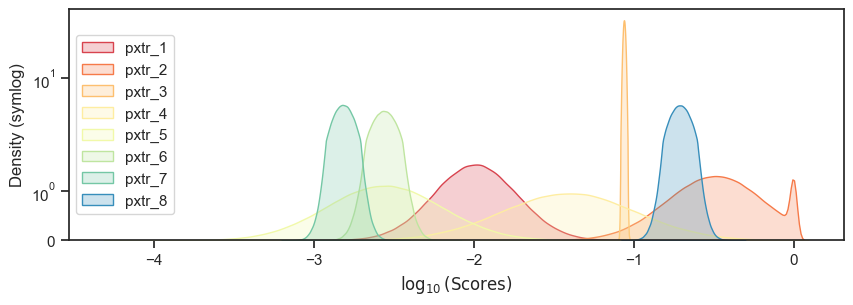

In [6]:
lpc.plot_logarithm_distributions()

In [7]:
lpc.first_order_weights

array([1195.71017173,   38.34785924,  139.92362803,  311.18549847,
       4428.74565794, 4434.87091289, 7978.12356702,   62.54112171])

In [8]:
lpc.power_weights

array([ 5.17466075e-06,  8.09253055e-05,  2.14145591e-06, -6.37968276e-05,
        4.60556461e-01,  1.33846796e-04,  1.15072043e-05, -2.50891317e-05])

18:02:45 - INFO - Calculating cumulative product of scores...


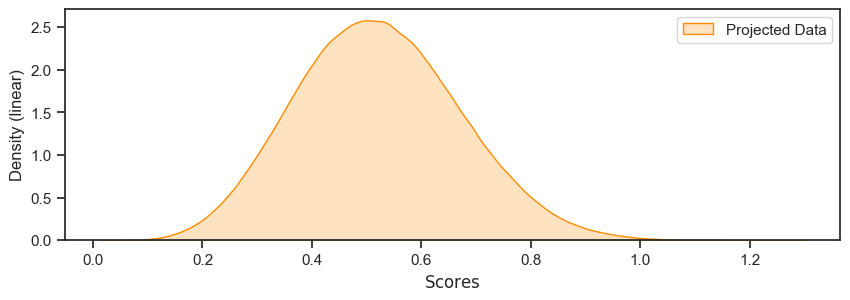

In [9]:
lpc.plot_self_balancing_projected_distribution()

In [10]:
lpc.pca_default_weights

array([1., 2., 1., 2., 5., 3., 1., 1.])

In [11]:
lpc.update(
    pca_weights=[1, 1, 1, 1, 1, 1, 1, 1],
)

18:02:47 - INFO - Calculating weighted PCA...
18:02:47 - INFO - Performing weighted logarithm PCA on the normalized data...
18:02:47 - INFO - Calculating cumulative product of scores...


In [12]:
lpc.first_order_weights

array([ 1779.68036034,    57.07648356,   208.26061251,   463.16468082,
        6591.69074141,  6600.80749577, 11874.54130634,    93.08543881])

In [13]:
lpc.power_weights

array([ 1.07090501e-03,  5.86283602e-04,  1.47052722e-05,  3.95730848e-01,
       -3.01932796e-04,  2.12367489e-04,  1.30390554e-04,  6.93191492e-06])

18:02:58 - INFO - Calculating cumulative product of scores...


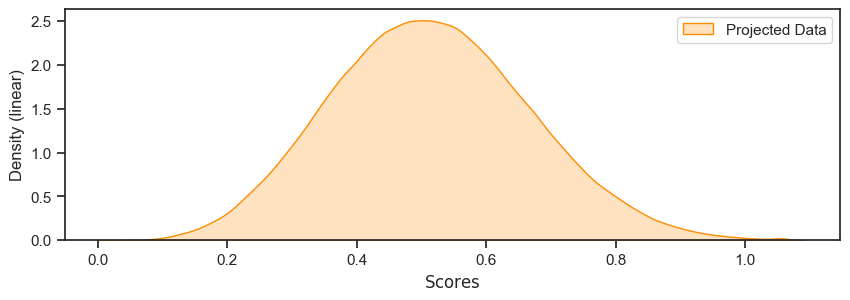

In [14]:
lpc.plot_self_balancing_projected_distribution()